<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures](Introduction.ipynb) › Lecture 45 - Kalmans Filters
***

# Kalman Filters

By Evgenia "Jenny" Nitishinskaya, Dr. Aidan O'Mahony, and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Kalman Filter Beta Estimation Example from [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)

## What is a Kalman Filter?

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:
1. Take as input a mathematical model of the system, i.e.
  * the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
  * the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
  * any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
  * covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
2. Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
3. At each timestep:
  * estimate the current state of the system $x_t$ using the transition matrix
  * take as input new measurements $z_t$
  * use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$

[This graphic](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg) illustrates the procedure followed by the algorithm. 

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

NOTE: this uses the <code>pykalman</code> module which is not installed by default. To install it, execute the following cell:

In [1]:
!pip install pykalman

     |████████████████████████████████| 228 kB 2.8 MB/s eta 0:00:01
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=61d660724c92bb0ecd9148b45d04c9bf31644cfa2959209759db0745beb983a1
  Stored in directory: /root/.cache/pip/wheels/11/16/21/615e29f0001ed6258b25d2a3a84ccfd65c5469b3505d4ab3ab
Successfully built pykalman


In [2]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

## Toy example: falling ball

Imagine we have a falling ball whose motion we are tracking with a camera. The state of the ball consists of its position and velocity. We know that we have the relationship $x_t = x_{t-1} + v_{t-1}\tau - \frac{1}{2} g \tau^2$, where $\tau$ is the time (in seconds) elapsed between $t-1$ and $t$ and $g$ is gravitational acceleration. Meanwhile, our camera can tell us the position of the ball every second, but we know from the manufacturer that the camera accuracy, translated into the position of the ball, implies variance in the position estimate of about 3 meters.

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state. The state of the system is (position, velocity), so it follows the transition matrix
$$ \left( \begin{array}{cc}
1 & \tau \\
0 & 1 \end{array} \right) $$

with offset $(-\tau^2 \cdot g/2, -\tau\cdot g)$. The observation matrix just extracts the position coordinate, (1  0), since we are measuring position. We know that the observation variance is 1, and transition covariance is 0 since we will be simulating the data the same way we specified our model. For the inital state, let's feed our model something bogus like (30, 10) and see how our system evolves.

In [3]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [4]:
# Create a simulation of a ball falling for 40 units of time (each of length tau)
times = np.arange(40)
actual = -4.9*tau**2*times**2

# Simulate the noisy camera data
sim = actual + 3*np.random.randn(40)

# Run filter on camera data
state_means, state_covs = kf.filter(sim)

/opt/conda/lib/python3.8/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


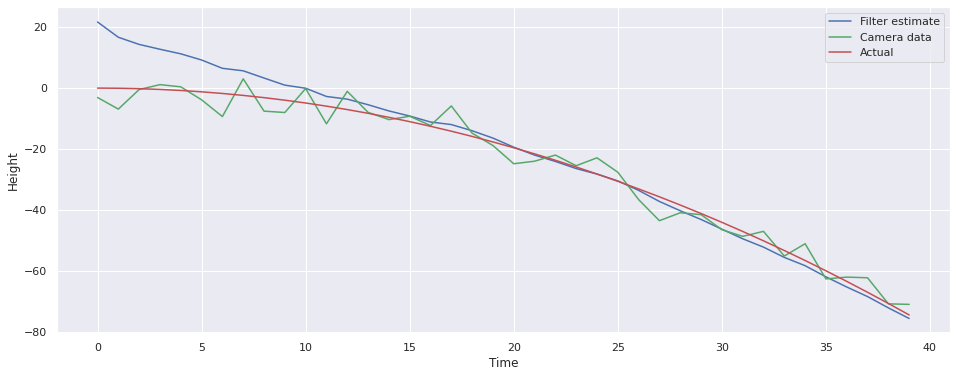

In [5]:
plt.plot(times, state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

At each point in time we plot the state estimate <i>after</i> accounting for the most recent measurement, which is why we are not at position 30 at time 0. The filter's attentiveness to the measurements allows it to correct for the initial bogus state we gave it. Then, by weighing its model and knowledge of the physical laws against new measurements, it is able to filter out much of the noise in the camera data. Meanwhile the confidence in the estimate increases with time, as shown by the graph below:

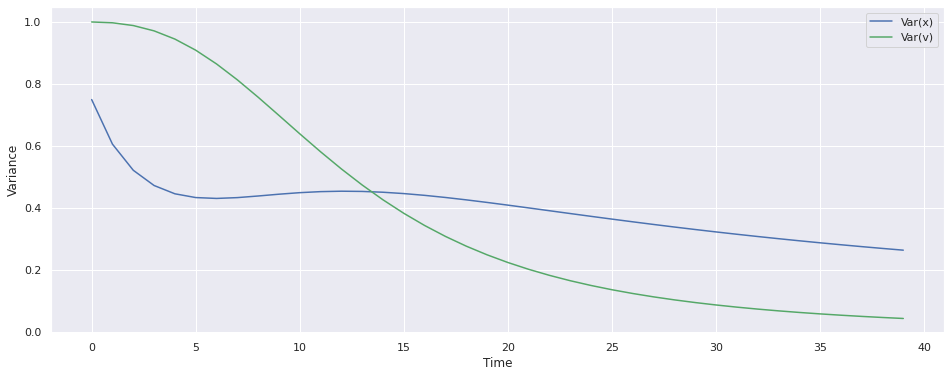

In [6]:
# Plot variances of x and v, extracting the appropriate values from the covariance matrix
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(v)'])
plt.ylabel('Variance')
plt.xlabel('Time');

The Kalman filter can also do <i>smoothing</i>, which takes in all of the input data at once and then constructs its best guess for the state of the system in each period post factum. That is, it does not provide online, running estimates, but instead uses all of the data to estimate the historical state, which is useful if we only want to use the data after we have collected all of it.

/opt/conda/lib/python3.8/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


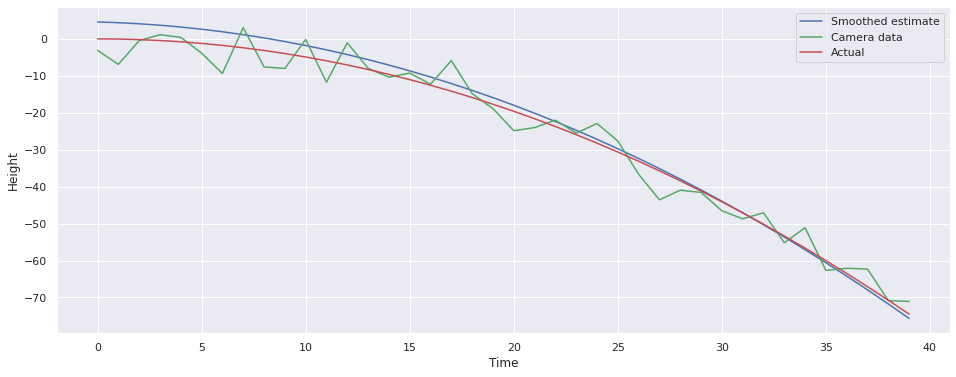

In [7]:
# Use smoothing to estimate what the state of the system has been
smoothed_state_means, _ = kf.smooth(sim)

# Plot results
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

## Example: moving average

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is estimation of rolling parameters of the data. When using a Kalman filter, there's no window length that we need to specify. This is useful for computing the moving average if that's what we are interested in, or for smoothing out estimates of other quantities. For instance, if we have already computed the moving Sharpe ratio, we can smooth it using a Kalman filter.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We hope that the mean describes our observations well, so it shouldn't change too much when we add an observation; therefore, we assume that it evolves as a random walk with a small error term. The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.

/opt/conda/lib/python3.8/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


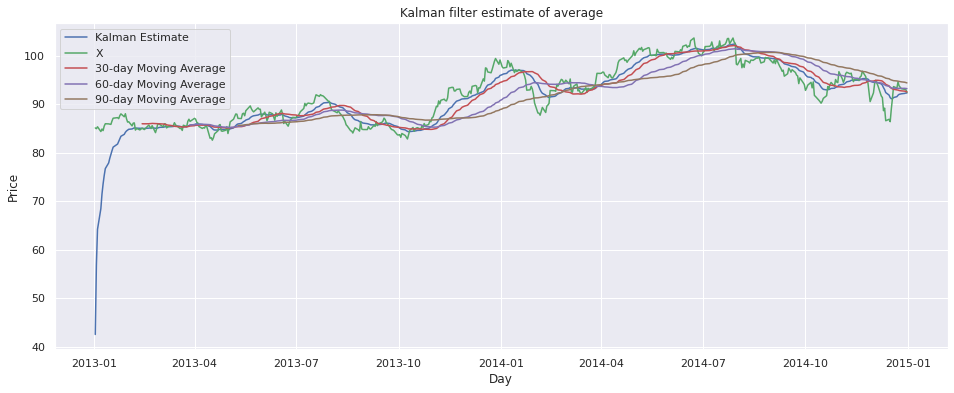

In [8]:
from quantrocket.master import get_securities
from quantrocket import get_prices

XOM = get_securities(symbols='XOM', vendors='usstock').index[0]

# Load pricing data for a security
start = '2013-01-01'
end = '2015-01-01'

x = get_prices(
    'usstock-free-1min', 
    data_frequency='daily',
    sids=XOM,
    fields='Close', 
    start_date=start, 
    end_date=end).loc['Close'][XOM]

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

This is a little hard to see, so we'll plot a subsection of the graph.

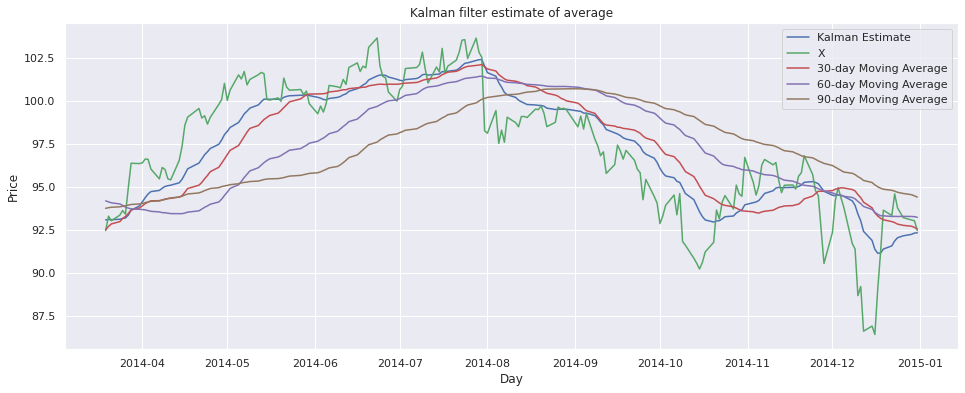

In [9]:
plt.plot(state_means[-200:])
plt.plot(x[-200:])
plt.plot(mean30[-200:])
plt.plot(mean60[-200:])
plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

The advantage of the Kalman filter is that we don't need to select a window length, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.

## Example: linear regression

Let's try using a Kalman filter to find linear regression lines for a dataset. We'll be comparing a stock price with the S&P 500, so the result will be a sort of rolling alpha and beta for the stock, where $\alpha$ and $\beta$ are the parameters of the linear regression equation
$$ y_t \approx \alpha + \beta x_t $$

Below we use colors to indicate the dates that the data points $(x_t, y_t)$ correspond to.

In [10]:
# Load pricing data

securities = get_securities(symbols=['AAPL', 'SPY'], vendors='usstock')

start = '2012-01-01'
end = '2015-01-01'

prices = get_prices(
    'usstock-free-1min',
    data_frequency='daily',
    sids=securities.index.tolist(),
    start_date=start,
    end_date=end,
    fields='Close').loc['Close']

sids_to_symbols = securities.Symbol.to_dict()
prices = prices.rename(columns=sids_to_symbols)

y = prices['AAPL']
x = prices['SPY']

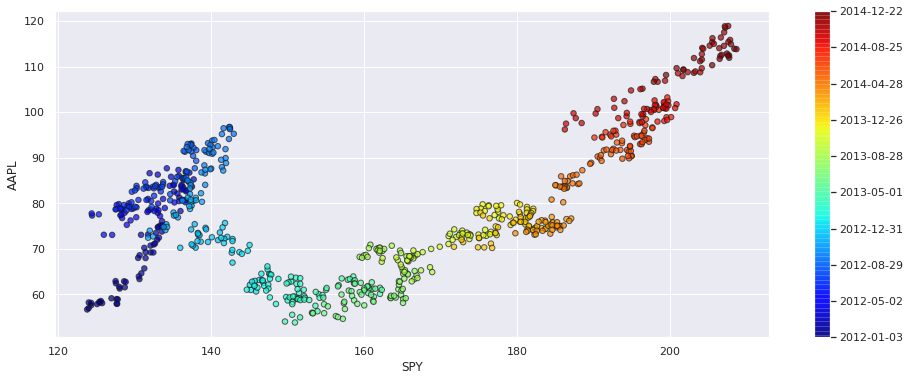

In [11]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('SPY')
plt.ylabel('AAPL');

Let's figure out the inputs to our Kalman filter. We'll say that the state of our system is the line that the observations are following, with parameters $\alpha$ and $\beta$. Our inital guesses for these parameters is (0,0), with a covariance matrix (which describes the error of our guess) of all ones. As in the example of the rolling mean, we assume that our parameters follow a random walk (transition matrix is the identity) with a small error term (transition covariance is a small number times the identity).

To get from the state of our system to an observation, we dot the state $(\beta, \alpha)$ with $(x_i, 1)$ to get $\beta x_i + \alpha \approx y_i$, so our observation matrix is just a column of 1s glued to $x$. We assume that the variance of our observations $y$ is 2. Now we are ready to use our observations of $y$ to evolve our estimates of the parameters $\alpha$ and $\beta$.

In [12]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [13]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

Below we plot the means - that is, our best estimates - of $\alpha$ and $\beta$ over time.

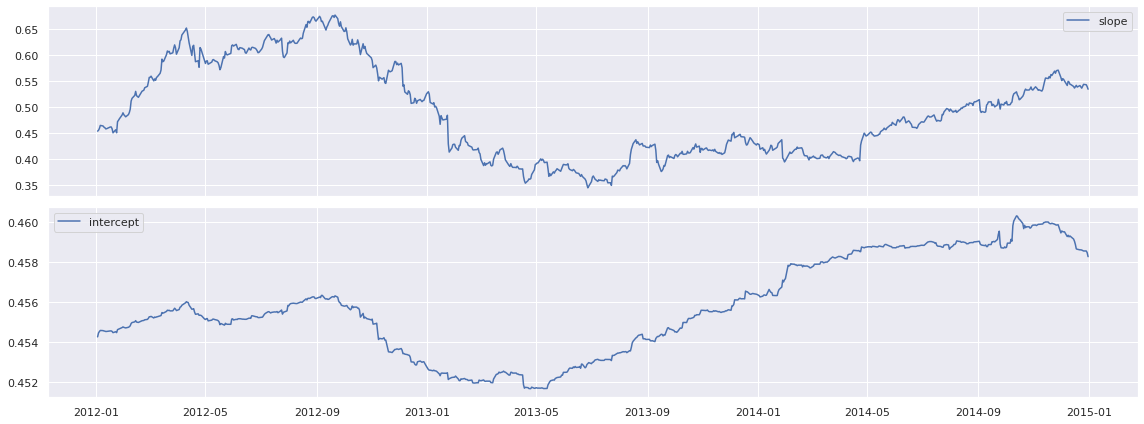

In [14]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

Notice how much the parameters fluctuate over long periods of time. If we are basing a trading algorithm on this, such as something that involves beta hedging, it's important to have the best and most current estimate of the beta. To visualize how the system evolves through time, we plot every fifth state (linear model) below. For comparison, in black we have the line returned by using ordinary least-squares regression on the full dataset, which is very different.

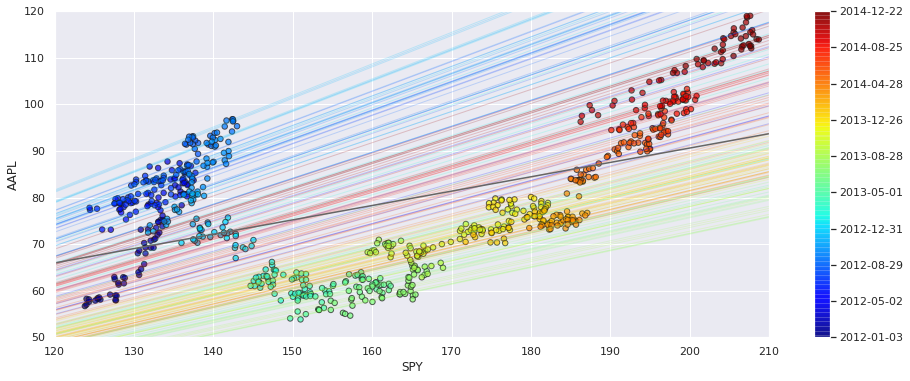

In [15]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([120, 210, 50, 120])

# Label axes
plt.xlabel('SPY')
plt.ylabel('AAPL');

Notice that although all of the state estimates take into account all previous observations, they fit the more recent data better than the older data. This allows the filter to adapt to structural changes in the data over time.

Now, most of the time we care about correlation in returns more than correlation in prices, so let's quickly use the same linear regression structure on the returns data:

/opt/conda/lib/python3.8/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


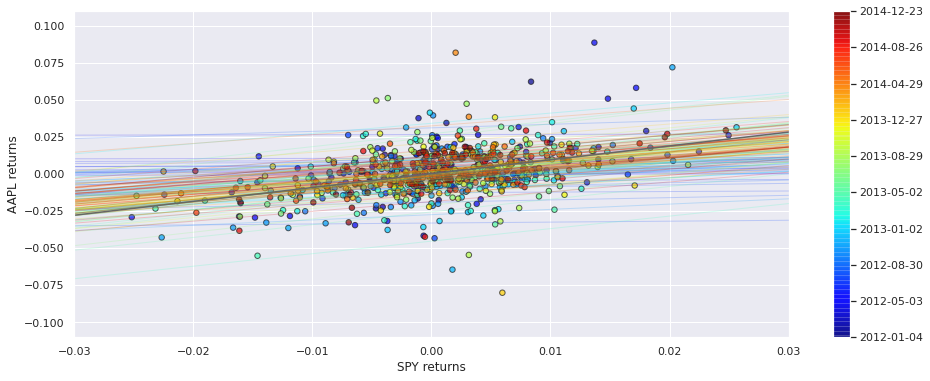

In [16]:
# Get returns from pricing data
x_r = x.pct_change()[1:]
y_r = y.pct_change()[1:]

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-0.03,0.03,-0.11, 0.11])

# Label axes
plt.xlabel('SPY returns')
plt.ylabel('AAPL returns');

Although the raw data is much more jumbled here, we can see the regression line evolving, even swinging past the OLS regression line.

## Generalizations

We can use a Kalman filter to model non-linear transition and observation functions, as well. For this purpose there exist extended and unscented Kalman filters, the latter of which is included in `pykalman`. These can even model situations where noise is not additive (for example, where noise is proportional to the size of the measurement). We can also specify non-Gaussian errors; this is useful in financial data, which tends to have heavy-tailed distributions.

There are also algorithms for inferring some of the input parameters, such as the covariance matrices and initial state, from an initial set of data. This can be done with the `pykalman.em()` method.

---

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*